# Lab Assignment Six: CCNs

## Preparation

By : Katie Rink

In [2]:
# Importing Tools
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import re
import plotly
from sklearn.utils import shuffle
from plotly.graph_objs import Bar, Line
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
from sklearn.decomposition import PCA
import os, random, shutil
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import cv2
from random import *

%matplotlib inline

#Referenced Datalira at https://www.kaggle.com/databeru
#Create a list with the filepaths
dir = Path('../Data/Lego_Images/')
    
file_paths = list(dir.glob(r'**/*.png'))

df = [str(x) for x in file_paths[::15]]
df = pd.DataFrame({'Filepath':file_paths[::15]})
img_wh = 150

#Add Labels from path
def get_label(string):
    #Isolate name from path
    label  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[1:-1])
    label = label.lower()
    #remove initial id value
    label = label[re.search(r'[a-z]', label).start():]
    find = re.compile(r"^[^\d]*")
    label = re.search(find, label).group(0)
    return label
           
# Retrieve the label from the path of the pictures
df['Label'] = df['Filepath'].apply(lambda x: get_label(str(x)))
NUM_CLASSES = len(df.Label.unique())

X = []
y = df['Label']

#Convert images to a numpy arrays
for path in df['Filepath'] : 
    image = cv2.imread(str(path))
    image = cv2.resize(image, (img_wh, img_wh))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    X.append(image.flatten())
    
X = np.array(X)

print("A visualization of the table of 1-D image features (each row = one image):")
print('The shape of the set: ' + str(X.shape))

2022-12-05 12:57:55.086443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


A visualization of the table of 1-D image features (each row = one image):
The shape of the set: (612, 22500)


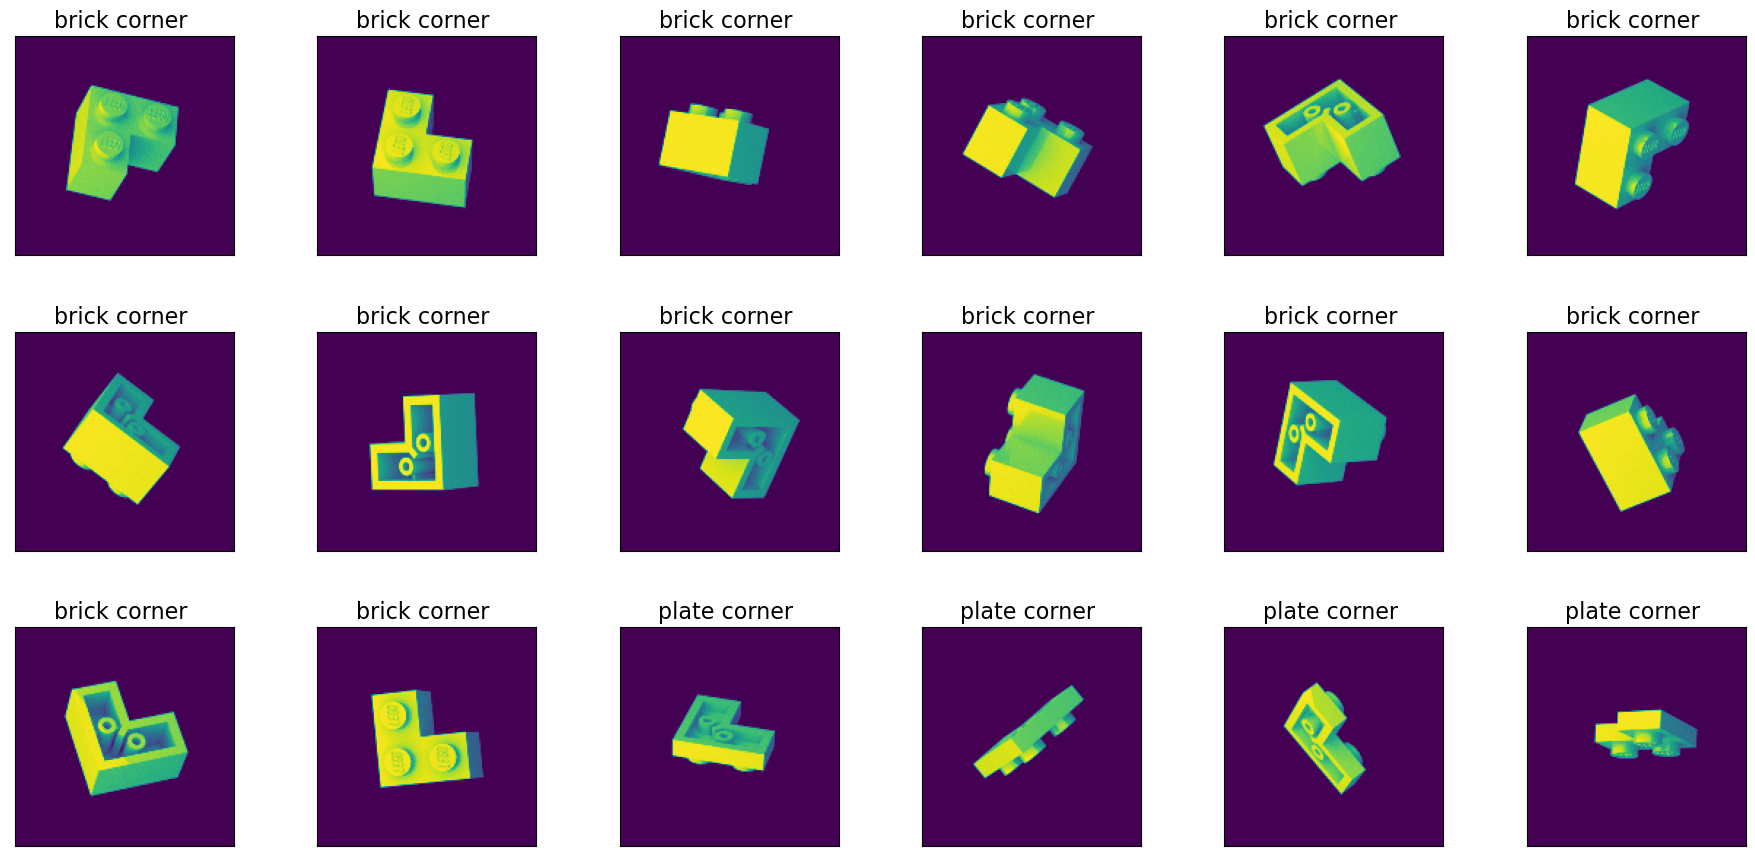

In [3]:
# a helper plotting function
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((img_wh,img_wh,1)))
        plt.title(titles[i], size=16)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, y) # defaults to showing a 3 by 6 subset of the images

In [4]:
labels = {}
unique = y.unique()
index = 0
for l in unique : 
    labels[l] = index
    y[y == l] = index
    index += 1
    
for key in labels : 
    print(key, ": ",labels[key]) 
print(y)

brick corner  :  0
plate corner  :  1
peg with friction :  2
brick  :  3
plate  :  4
roof tile  :  5
round brick  :  6
roof corner outside tile  :  7
roof corner inside tile  :  8
curved brick  :  9
flat tile  :  10
brick bow  :  11
roof tile outside  :  12
technic brick  :  13
flat tile round  :  14
connector peg w knob :  15
brick d :  16
lever  :  17
flat tile corner  :  18
beam  :  19
cross block fork  :  20
bush  :  21
roof tile inside  :  22
0       0
1       0
2       0
3       0
4       0
       ..
607    22
608    22
609    22
610    22
611    22
Name: Label, Length: 612, dtype: object


### Metric

In this case, it doesn't particularly matter how many false positives or negatives there are. The consequences that come with misclassifying a lego would be inconsequential, so it is more important that we focus purely on accuracy. Therefore, in this rare case, we want to focus on identifying accuracy as our primary case. Given that our general goal in classification would be to allow for ease of sorting of legos, in this use case, it's just as important to have to correct in the right class as it is to not put the wrong pieces in the wrong class. 

### Splitting the Data

Now that we have all our data set. We need to divide into training and testing utilizing a 80%-20% split. We know that it's a realistic mirroring because the dataset we are using contains equal numbers of all of the classes, as is noted in it's description. Additionally, it is well over 100 images, so any kind of split is ensured to get a good number of each sample. 

In [5]:
from sklearn.model_selection import train_test_split

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

#fixing the sizes, channels last
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))

Rows: 489, columns: 22500
Rows: 123, columns: 22500
New Shape: Rows: 489, image size: (150,150,1)


## Modeling

### Set-up with Keras

Now that we have all our data, I will traing the data using Keras. I utilized the technique that we set up in class. I first created a method to generate a data expansion on all of my images.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

/users/krink/.conda/envs/tensorflow_env/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


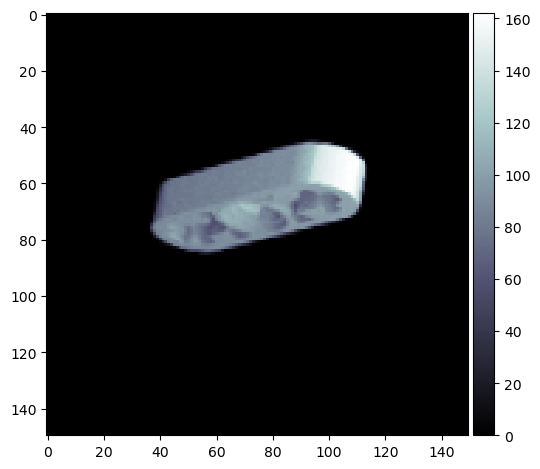

In [7]:
from skimage.io import imshow

tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    break

### Convolutional Neural Network

Once I was certain that my images were ready, I utilized Dr. Larson's function to create a heatmap of accuracy, a function to find the accuracy of a neural network, and two functions to compile a neural network using RMSprops and ADAdelta optimizers. That way, with every convolutional neural network I create, I am able to test it against both optimizers, graph it, and find it's accuracy. 

In [8]:
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from scikeras.wrappers import KerasClassifier

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(20,20))
    yhat = np.argmax(net.predict(X_test), axis=1)
    yhat = np.asarray(yhat, dtype=np.float64)
    y_test =  np.asarray(y_test, dtype=np.float64)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels.keys())
    plt.title(title_text+"\nAccuracy: "+'{:.4f}'.format(acc))
    
def determine_accuracy(net, X_test, y_test):
    yhat = np.argmax(net.predict(X_test), axis=1)
    yhat = np.asarray(yhat, dtype=np.float64)
    y_test =  np.asarray(y_test, dtype=np.float64)
    
    acc = mt.accuracy_score(y_test,yhat)
    return acc

In [9]:
#Compile w/ RMS Props
def compile_RMS(cnn) :
    # Let's train the model 
    cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

    # the flow method yields batches of images indefinitely, with the given transformations
    cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )
    return cnn

#Compile with ADA Delta
def compile_ADA(cnn) :
    # Let's train the model 
    cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adadelta', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

    # the flow method yields batches of images indefinitely, with the given transformations
    cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )
    return cnn

Now I need to be able to actually create the Convolutional Neural Network, so I created the below function to create it. It adds the convolutional layers at a specified Kernel size and a specified number of filters, then it pools them. From there it is flattened and minimized. 

In [10]:
def create_cnn(fil, kernelsize):
    cnn = Sequential()

    # let's start with an AlexNet style convolutional phase
    cnn.add(Conv2D(filters=fil,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(kernelsize,kernelsize), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

    # no max pool before next conv layer!!
    cnn.add(Conv2D(filters=fil,
                kernel_size=(kernelsize,kernelsize), 
                padding='same', 
                activation='relu')) # more compact syntax
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

    # add one layer on flattened output
    cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
    cnn.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return cnn

#### Architecture 1

Given that I have the basic architecture set out above to be to develop a CNN and run it. Now I want to test against one of it's primary components to see it's affect, Kernels. I tested from a ragne of 1-10 kernels utilized, while keeping all other factors constant. That way I could get a good look at generally what kind of affect it had. 

##### Model 1

First, I found which kernel yielded the highest accuracy, as that is our chosen metric, and saved it to be fully compiled with the RMSprops optimizer. From this, I can see that it is very accurate at identifying standard bricks, but not much else. Additionally, I found that the ideal kernel quantity was 5.

In [46]:
highest_acc = -1
kernel_at_highest = -1

for i in range(1, 10) : 
    kernel_size = i
    filters = 32
    
    cnn = create_cnn(filters, kernel_size)
    cnn = compile_RMS(cnn)
    acc = determine_accuracy(cnn, X_test, y_test)
    if(acc > highest_acc) :
        highest_acc = acc
        kernel_at_highest = kernel_size

/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 8s 2s/step - loss: 466.2029 - accuracy: 0.0970 - val_loss: 108.5368 - val_accuracy: 0.1789
Epoch 2/5
3/3 [==============================] - 7s 2s/step - loss: 92.5887 - accuracy: 0.0720 - val_loss: 3.9265 - val_accuracy: 0.0325
Epoch 3/5
3/3 [==============================] - 7s 2s/step - loss: 4.7600 - accuracy: 0.0443 - val_loss: 3.1907 - val_accuracy: 0.0488
Epoch 4/5
3/3 [==============================] - 7s 2s/step - loss: 3.3481 - accuracy: 0.1136 - val_loss: 3.1291 - val_accuracy: 0.1626
Epoch 5/5
4/4 [==============================] - 1s 111ms/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 10s 4s/step - loss: 545.0446 - accuracy: 0.1551 - val_loss: 220.6982 - val_accuracy: 0.1057
Epoch 2/5
3/3 [==============================] - 10s 3s/step - loss: 131.0824 - accuracy: 0.0720 - val_loss: 8.0754 - val_accuracy: 0.0732
Epoch 3/5
3/3 [==============================] - 10s 3s/step - loss: 5.6034 - accuracy: 0.0469 - val_loss: 3.4594 - val_accuracy: 0.0244
Epoch 4/5
3/3 [==============================] - 10s 3s/step - loss: 3.3299 - accuracy: 0.0443 - val_loss: 3.3770 - val_accuracy: 0.0325
Epoch 5/5
4/4 [==============================] - 1s 160ms/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 14s 4s/step - loss: 90.2187 - accuracy: 0.0748 - val_loss: 8.1838 - val_accuracy: 0.0894
Epoch 2/5
3/3 [==============================] - 13s 5s/step - loss: 6.5806 - accuracy: 0.1524 - val_loss: 3.7774 - val_accuracy: 0.1463
Epoch 3/5
3/3 [==============================] - 13s 4s/step - loss: 3.8036 - accuracy: 0.1080 - val_loss: 3.0421 - val_accuracy: 0.1220
Epoch 4/5
3/3 [==============================] - 13s 5s/step - loss: 3.4035 - accuracy: 0.0942 - val_loss: 2.8585 - val_accuracy: 0.1220
Epoch 5/5
4/4 [==============================] - 1s 226ms/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 19s 6s/step - loss: 57.1095 - accuracy: 0.1163 - val_loss: 6.4231 - val_accuracy: 0.1301
Epoch 2/5
3/3 [==============================] - 19s 6s/step - loss: 4.4176 - accuracy: 0.1524 - val_loss: 3.3494 - val_accuracy: 0.1626
Epoch 3/5
3/3 [==============================] - 19s 7s/step - loss: 3.0337 - accuracy: 0.1302 - val_loss: 2.9604 - val_accuracy: 0.1301
Epoch 4/5
3/3 [==============================] - 19s 6s/step - loss: 2.9843 - accuracy: 0.1274 - val_loss: 2.7846 - val_accuracy: 0.1789
Epoch 5/5
4/4 [==============================] - 1s 334ms/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 27s 9s/step - loss: 78.5158 - accuracy: 0.1172 - val_loss: 5.1821 - val_accuracy: 0.1707
Epoch 2/5
3/3 [==============================] - 26s 9s/step - loss: 3.9304 - accuracy: 0.1458 - val_loss: 3.3920 - val_accuracy: 0.1870
Epoch 3/5
3/3 [==============================] - 26s 9s/step - loss: 3.1094 - accuracy: 0.1589 - val_loss: 3.0692 - val_accuracy: 0.1626
Epoch 4/5
3/3 [==============================] - 25s 8s/step - loss: 2.9064 - accuracy: 0.1745 - val_loss: 2.9135 - val_accuracy: 0.1951
Epoch 5/5
4/4 [==============================] - 2s 479ms/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 44s 15s/step - loss: 103.2273 - accuracy: 0.0776 - val_loss: 5.4311 - val_accuracy: 0.0976
Epoch 2/5
3/3 [==============================] - 43s 16s/step - loss: 4.1195 - accuracy: 0.1080 - val_loss: 3.3714 - val_accuracy: 0.1545
Epoch 3/5
3/3 [==============================] - 43s 16s/step - loss: 3.1920 - accuracy: 0.1025 - val_loss: 2.9841 - val_accuracy: 0.1707
Epoch 4/5
3/3 [==============================] - 43s 14s/step - loss: 2.9592 - accuracy: 0.1496 - val_loss: 2.8584 - val_accuracy: 0.1707
Epoch 5/5
4/4 [==============================] - 3s 837ms/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 57s 19s/step - loss: 37.1892 - accuracy: 0.0886 - val_loss: 3.0650 - val_accuracy: 0.1545
Epoch 2/5
3/3 [==============================] - 56s 19s/step - loss: 2.9697 - accuracy: 0.1607 - val_loss: 2.8908 - val_accuracy: 0.1626
Epoch 3/5
3/3 [==============================] - 56s 20s/step - loss: 2.8759 - accuracy: 0.1801 - val_loss: 2.8375 - val_accuracy: 0.1382
Epoch 4/5
3/3 [==============================] - 56s 19s/step - loss: 2.8072 - accuracy: 0.2216 - val_loss: 2.7511 - val_accuracy: 0.1626
Epoch 5/5
4/4 [==============================] - 5s 1s/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 83s 28s/step - loss: 72.3482 - accuracy: 0.0677 - val_loss: 3.1300 - val_accuracy: 0.1626
Epoch 2/5
3/3 [==============================] - 78s 26s/step - loss: 3.0270 - accuracy: 0.1302 - val_loss: 2.8127 - val_accuracy: 0.1707
Epoch 3/5
3/3 [==============================] - 77s 26s/step - loss: 2.8881 - accuracy: 0.1607 - val_loss: 2.7511 - val_accuracy: 0.1707
Epoch 4/5
3/3 [==============================] - 82s 28s/step - loss: 2.8188 - accuracy: 0.1875 - val_loss: 2.7195 - val_accuracy: 0.1951
Epoch 5/5
4/4 [==============================] - 7s 2s/step


/tmp/ipykernel_28439/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 197s 69s/step - loss: 112.5871 - accuracy: 0.1385 - val_loss: 3.0923 - val_accuracy: 0.0813
Epoch 2/5
3/3 [==============================] - 196s 75s/step - loss: 3.0540 - accuracy: 0.1025 - val_loss: 2.9583 - val_accuracy: 0.1057
Epoch 3/5
3/3 [==============================] - 196s 69s/step - loss: 2.8831 - accuracy: 0.1634 - val_loss: 2.8873 - val_accuracy: 0.1626
Epoch 4/5
3/3 [==============================] - 178s 62s/step - loss: 2.8924 - accuracy: 0.1551 - val_loss: 2.7110 - val_accuracy: 0.1870
Epoch 5/5
4/4 [==============================] - 30s 7s/step


4/4 [==============================] - 2s 451ms/step


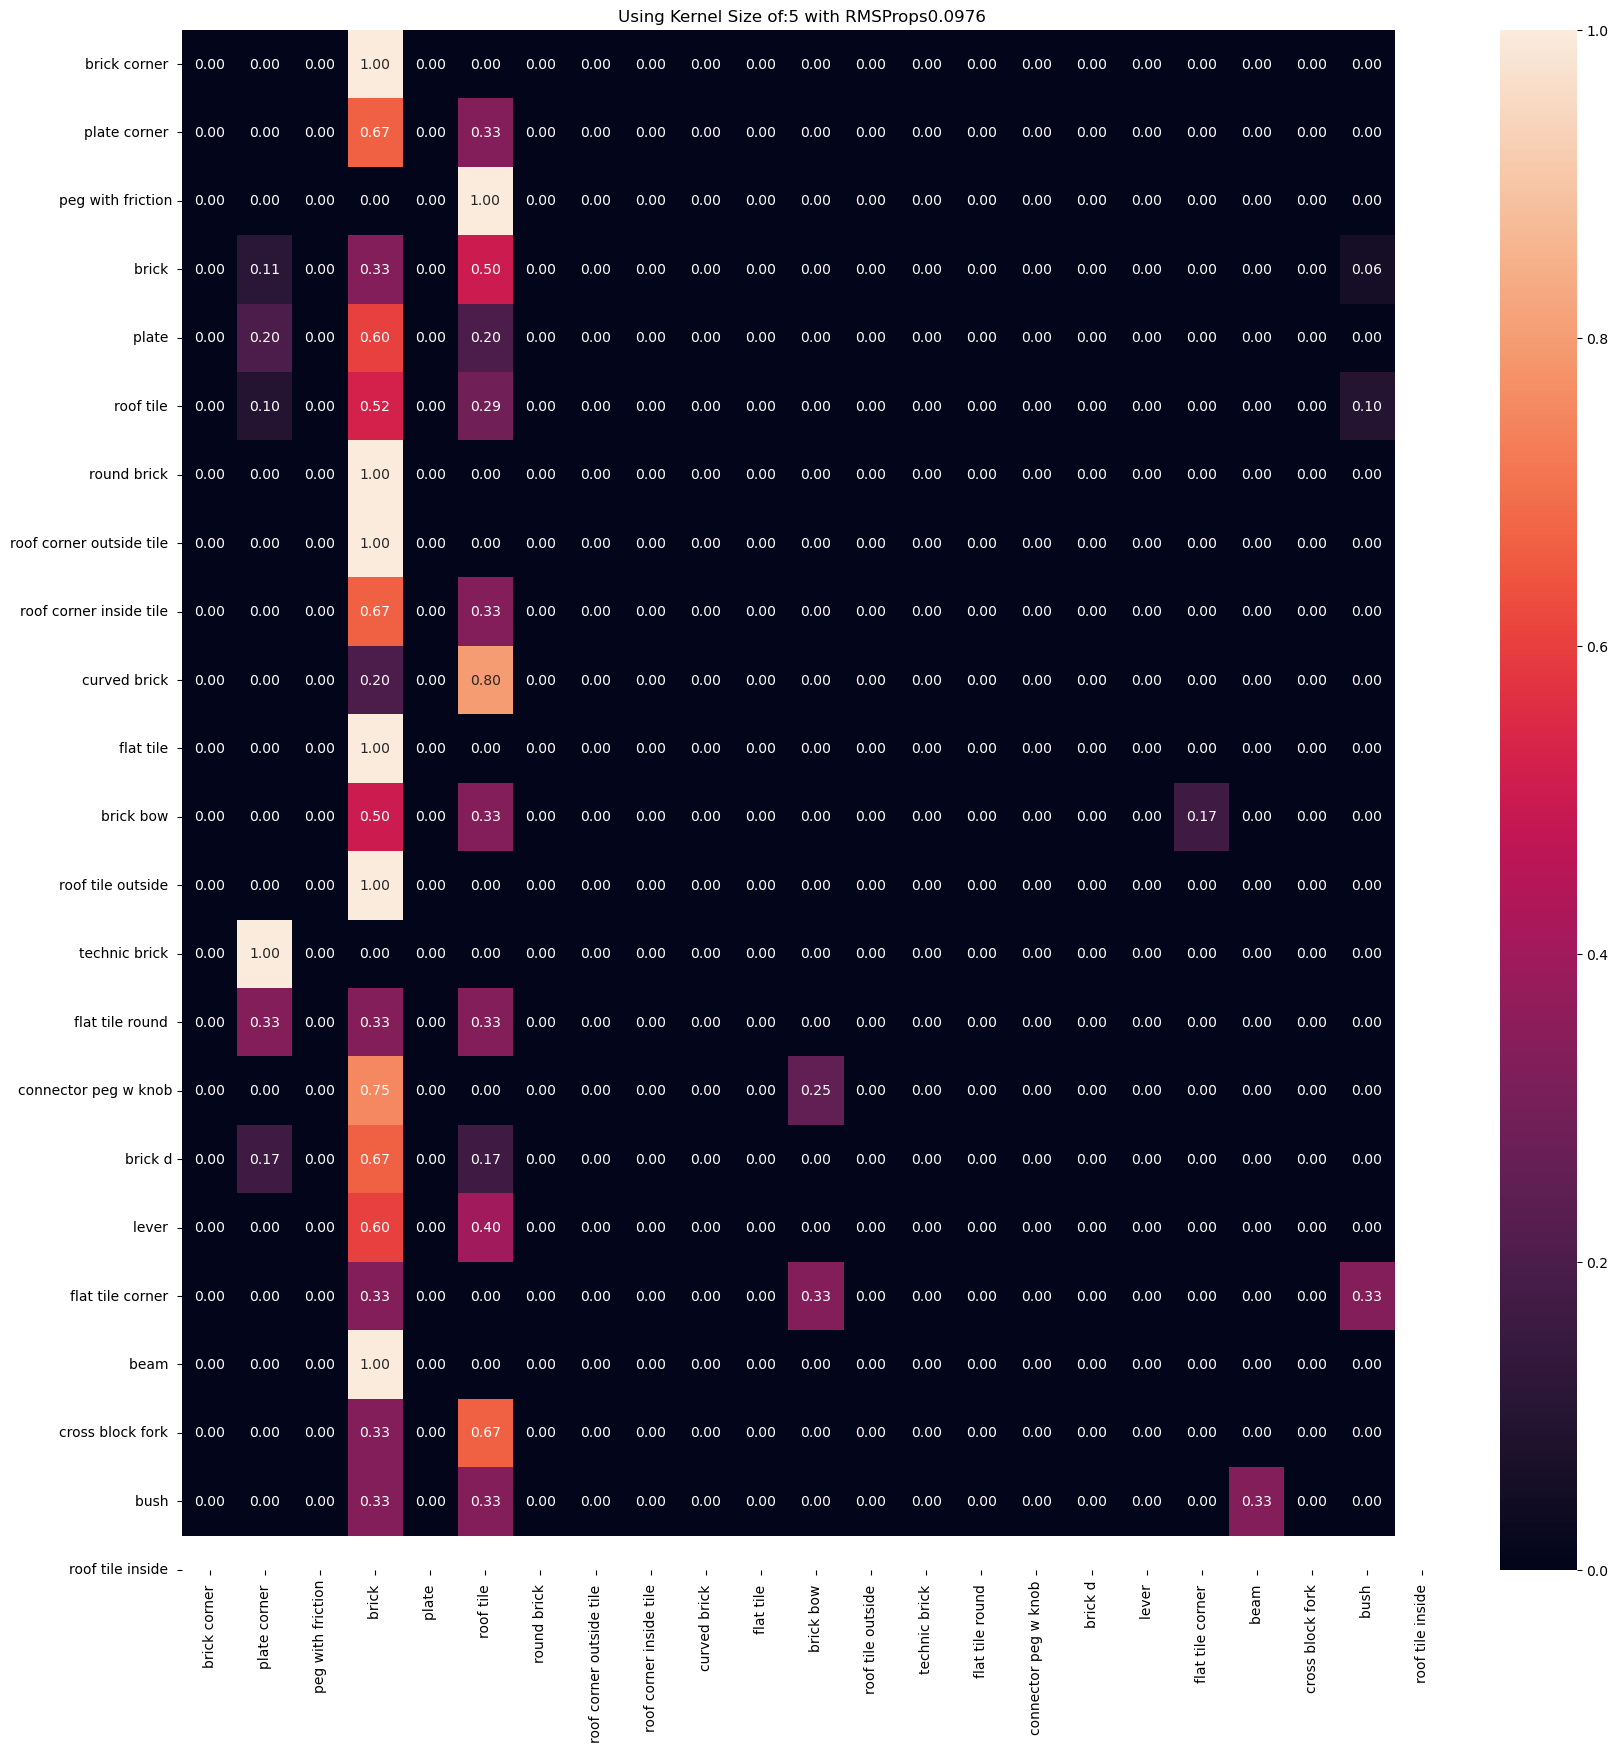

In [48]:
cnn = create_cnn(filters, kernel_at_highest)

summarize_net(cnn, X_test, y_test, title_text='Using Kernel Size of: ' + str(kernel_at_highest) + " with RMSProps")

##### Model 2

I then repeated the process with ADAdelta, and found that this optimizer allowed for a wider spread of recognition. It remained consistent that the optimal number of kernels was 5. 

In [50]:
highest_acc = -1
kernel_at_highest = -1

for i in range(1, 6) : 
    kernel_size = i
    filters = 32
    
    cnn = create_cnn(filters, kernel_size)
    cnn = compile_ADA(cnn)
    acc = determine_accuracy(cnn, X_test, y_test)
    if(acc > highest_acc) :
        highest_acc = acc
        kernel_at_highest = kernel_size

/tmp/ipykernel_28439/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 14.3110 - accuracy: 0.0360 - val_loss: 9.1325 - val_accuracy: 0.0407
Epoch 2/5
3/3 [==============================] - 7s 2s/step - loss: 13.5289 - accuracy: 0.0755 - val_loss: 8.2034 - val_accuracy: 0.0732
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 12.5766 - accuracy: 0.0609 - val_loss: 7.5082 - val_accuracy: 0.0813
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 12.4795 - accuracy: 0.0305 - val_loss: 7.0369 - val_accuracy: 0.1138
Epoch 5/5
4/4 [==============================] - 0s 109ms/step


/tmp/ipykernel_28439/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 10s 3s/step - loss: 27.5130 - accuracy: 0.0554 - val_loss: 15.9574 - val_accuracy: 0.0894
Epoch 2/5
3/3 [==============================] - 9s 3s/step - loss: 23.0391 - accuracy: 0.0859 - val_loss: 14.0357 - val_accuracy: 0.0894
Epoch 3/5
3/3 [==============================] - 10s 3s/step - loss: 23.0779 - accuracy: 0.0677 - val_loss: 12.7435 - val_accuracy: 0.0976
Epoch 4/5
3/3 [==============================] - 9s 3s/step - loss: 22.2894 - accuracy: 0.0609 - val_loss: 11.2449 - val_accuracy: 0.0976
Epoch 5/5
4/4 [==============================] - 1s 149ms/step


/tmp/ipykernel_28439/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 13s 4s/step - loss: 23.0069 - accuracy: 0.0277 - val_loss: 13.7864 - val_accuracy: 0.0163
Epoch 2/5
3/3 [==============================] - 13s 4s/step - loss: 21.7974 - accuracy: 0.0305 - val_loss: 12.3957 - val_accuracy: 0.0488
Epoch 3/5
3/3 [==============================] - 13s 5s/step - loss: 19.9832 - accuracy: 0.0573 - val_loss: 11.3196 - val_accuracy: 0.0732
Epoch 4/5
3/3 [==============================] - 13s 4s/step - loss: 18.1641 - accuracy: 0.0803 - val_loss: 10.5536 - val_accuracy: 0.1057
Epoch 5/5
4/4 [==============================] - 1s 218ms/step


/tmp/ipykernel_28439/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 19s 7s/step - loss: 21.2648 - accuracy: 0.0443 - val_loss: 12.2942 - val_accuracy: 0.0163
Epoch 2/5
3/3 [==============================] - 18s 6s/step - loss: 19.2326 - accuracy: 0.0388 - val_loss: 10.4736 - val_accuracy: 0.0325
Epoch 3/5
3/3 [==============================] - 19s 7s/step - loss: 17.4354 - accuracy: 0.0339 - val_loss: 9.0997 - val_accuracy: 0.0244
Epoch 4/5
3/3 [==============================] - 18s 6s/step - loss: 16.9524 - accuracy: 0.0332 - val_loss: 8.1023 - val_accuracy: 0.0569
Epoch 5/5
4/4 [==============================] - 1s 317ms/step


/tmp/ipykernel_28439/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 26s 9s/step - loss: 19.7201 - accuracy: 0.0573 - val_loss: 10.1695 - val_accuracy: 0.0244
Epoch 2/5
3/3 [==============================] - 24s 8s/step - loss: 17.6791 - accuracy: 0.0859 - val_loss: 9.1426 - val_accuracy: 0.0650
Epoch 3/5
3/3 [==============================] - 25s 9s/step - loss: 16.1077 - accuracy: 0.0964 - val_loss: 8.4888 - val_accuracy: 0.0732
Epoch 4/5
3/3 [==============================] - 24s 8s/step - loss: 16.0756 - accuracy: 0.0942 - val_loss: 8.0405 - val_accuracy: 0.1057
Epoch 5/5
4/4 [==============================] - 2s 454ms/step


4/4 [==============================] - 2s 487ms/step


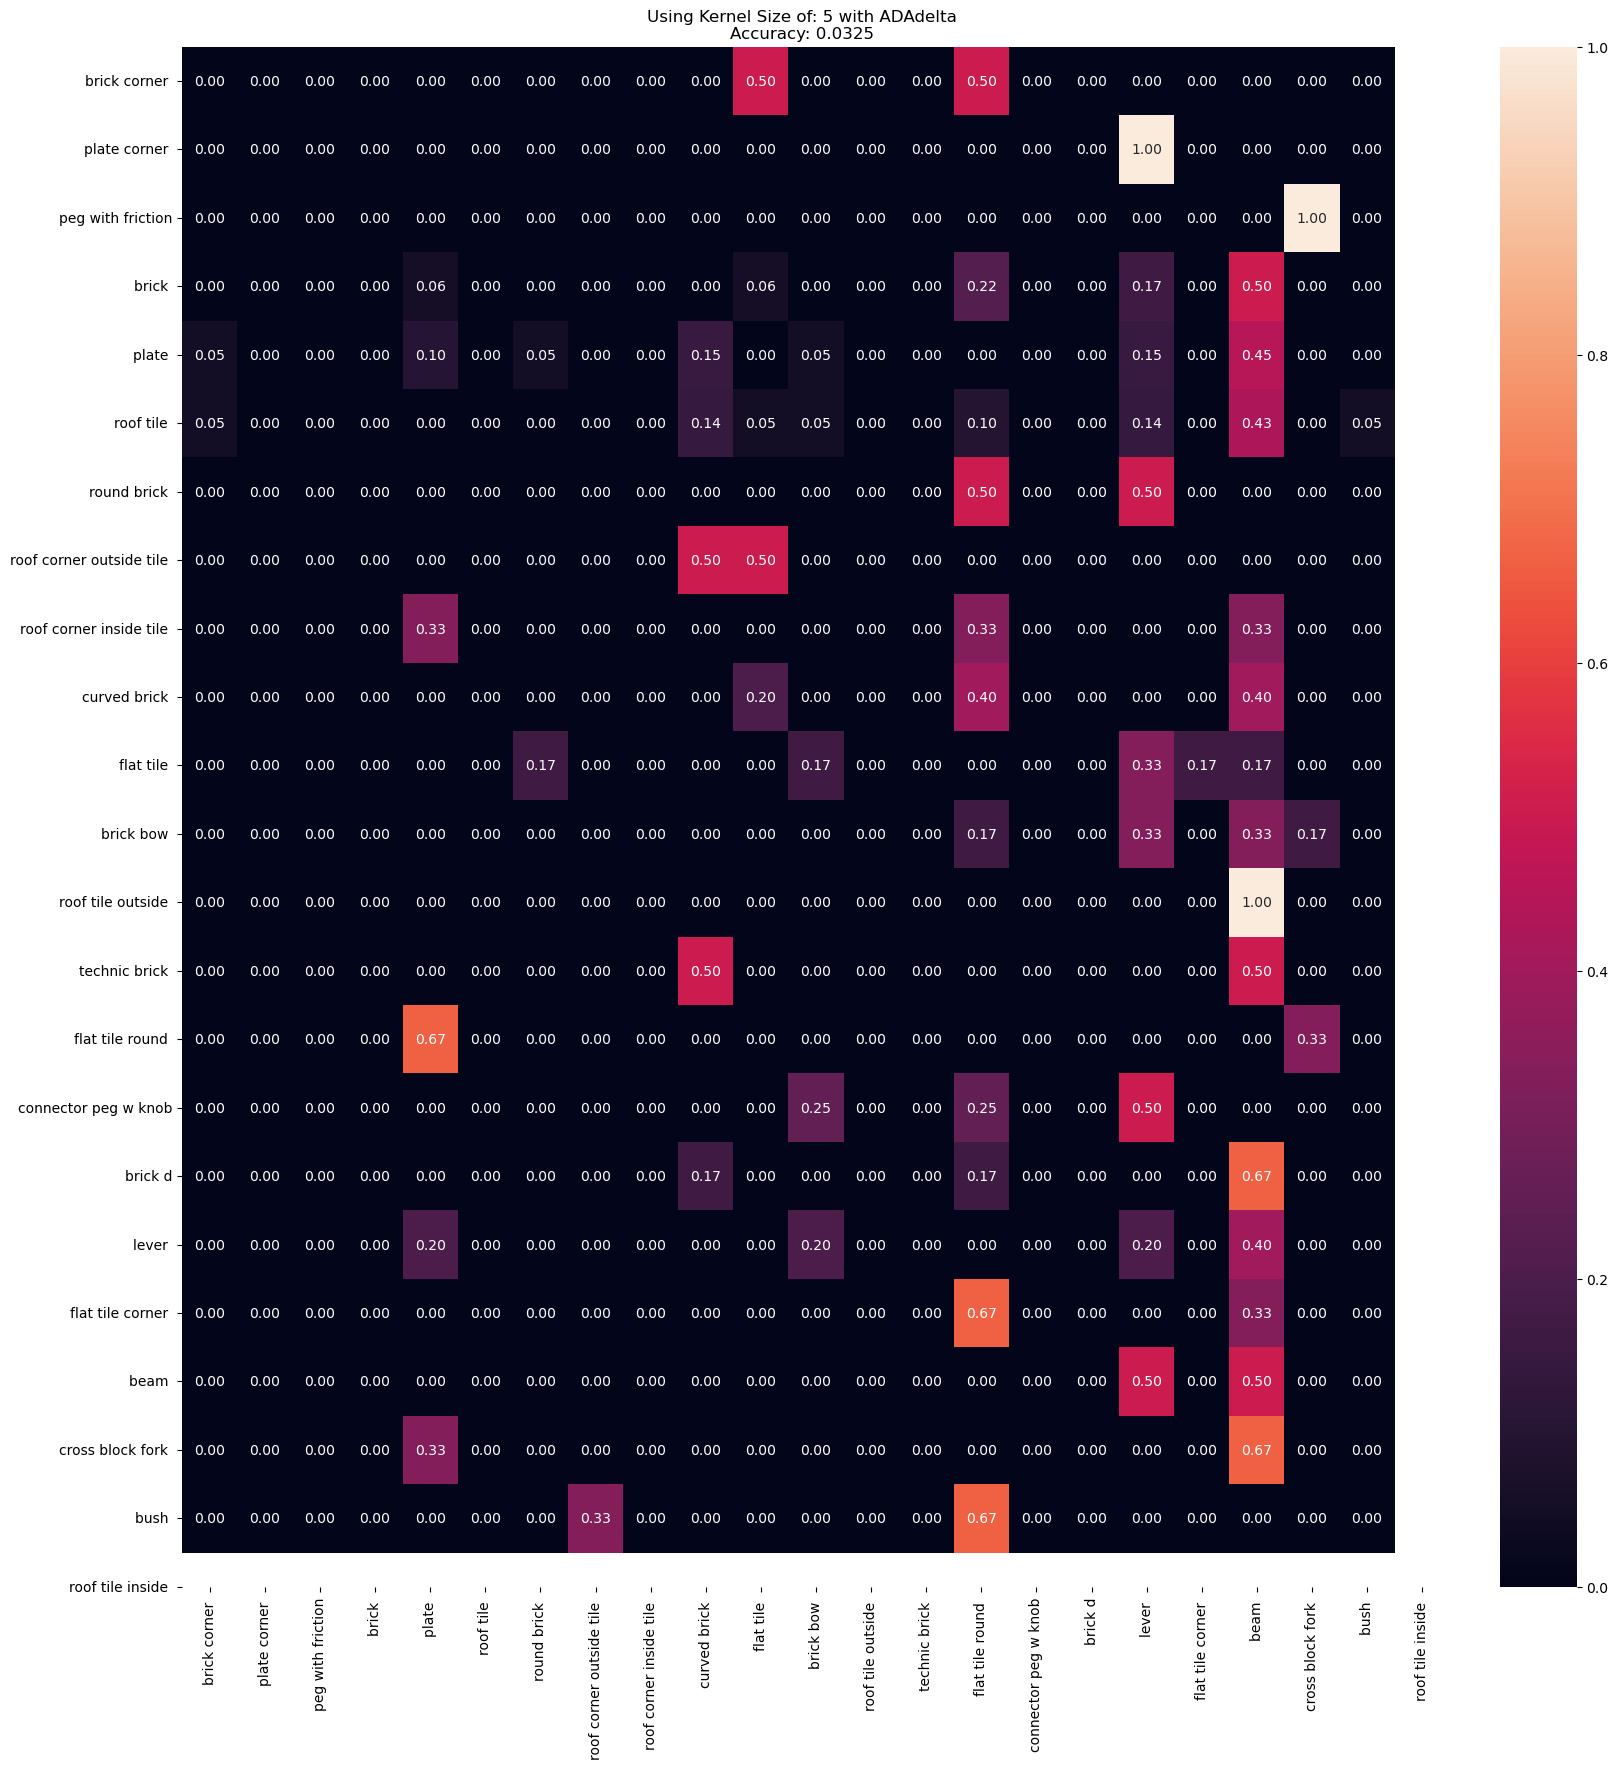

In [51]:
cnn = create_cnn(filters, kernel_at_highest)

summarize_net(cnn, X_test, y_test, title_text='Using Kernel Size of: ' + str(kernel_at_highest) + " with ADAdelta")

#### Architecture 2

Now that I have a good look at how Kernels affect the CNN, I wanted to look at the quantity of filters. I tried from a range of 8, 16, 32, 64, and 128, which seemed to be the range of standard filter sizes from my research. 

##### Model 1

Once I located the number of filters with the highest accuracy, I procceded to test it against RMSProps, similar to how I did above. From this I gathered that the optimal number of filters for accuracy was 128, and once again RMSprops was only skilled at locating one  object.  

In [11]:
highest_acc = -1
filter_at_highest = -1
filters = 8
while filters < 128 : 
    kernel_size = 3
    filters *= 2
    print(filters)
    
    cnn = create_cnn(filters, kernel_size)
    cnn = compile_RMS(cnn)
    acc = determine_accuracy(cnn, X_test, y_test)
    if(acc > highest_acc) :
        highest_acc = acc
        filter_at_highest = filters

16


2022-12-04 20:10:02.314431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 20:10:02.314601: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/tmp/ipykernel_27156/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 234.5950 - accuracy: 0.0703 - val_loss: 73.2165 - val_accuracy: 0.1707
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 46.8349 - accuracy: 0.0831 - val_loss: 3.5867 - val_accuracy: 0.0813
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 4.4441 - accuracy: 0.0776 - val_loss: 3.2028 - val_accuracy: 0.0569
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 3.4924 - accuracy: 0.0637 - val_loss: 3.1263 - val_accuracy: 0.1707
Epoch 5/5
4/4 [==============================] - 0s 97ms/step
32


/tmp/ipykernel_27156/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 14s 5s/step - loss: 95.2118 - accuracy: 0.1053 - val_loss: 8.9550 - val_accuracy: 0.2439
Epoch 2/5
3/3 [==============================] - 13s 4s/step - loss: 7.1803 - accuracy: 0.1136 - val_loss: 3.6317 - val_accuracy: 0.0976
Epoch 3/5
3/3 [==============================] - 13s 5s/step - loss: 3.5698 - accuracy: 0.1080 - val_loss: 3.0113 - val_accuracy: 0.1220
Epoch 4/5
3/3 [==============================] - 14s 5s/step - loss: 3.2106 - accuracy: 0.1120 - val_loss: 2.9419 - val_accuracy: 0.1138
Epoch 5/5
4/4 [==============================] - 1s 226ms/step
64


/tmp/ipykernel_27156/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 46s 15s/step - loss: 162.4356 - accuracy: 0.0729 - val_loss: 5.9566 - val_accuracy: 0.1138
Epoch 2/5
3/3 [==============================] - 42s 14s/step - loss: 5.3675 - accuracy: 0.0886 - val_loss: 3.2682 - val_accuracy: 0.1545
Epoch 3/5
3/3 [==============================] - 42s 14s/step - loss: 3.4940 - accuracy: 0.1025 - val_loss: 2.9495 - val_accuracy: 0.1545
Epoch 4/5
3/3 [==============================] - 45s 15s/step - loss: 3.0591 - accuracy: 0.1406 - val_loss: 2.8482 - val_accuracy: 0.1789
Epoch 5/5
4/4 [==============================] - 3s 730ms/step
128


/tmp/ipykernel_27156/194493443.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 170s 57s/step - loss: 223.1415 - accuracy: 0.0720 - val_loss: 3.0427 - val_accuracy: 0.1301
Epoch 2/5
3/3 [==============================] - 202s 74s/step - loss: 3.1575 - accuracy: 0.0886 - val_loss: 2.8024 - val_accuracy: 0.1626
Epoch 3/5
3/3 [==============================] - 232s 80s/step - loss: 2.9743 - accuracy: 0.1250 - val_loss: 2.8392 - val_accuracy: 0.2602
Epoch 4/5
3/3 [==============================] - 219s 74s/step - loss: 2.8158 - accuracy: 0.1717 - val_loss: 2.8464 - val_accuracy: 0.3008
Epoch 5/5
4/4 [==============================] - 18s 4s/step


4/4 [==============================] - 18s 4s/step


/tmp/ipykernel_27156/796560467.py:13: RuntimeWarning: invalid value encountered in divide
  cm = cm/np.sum(cm,axis=1)[:,np.newaxis]


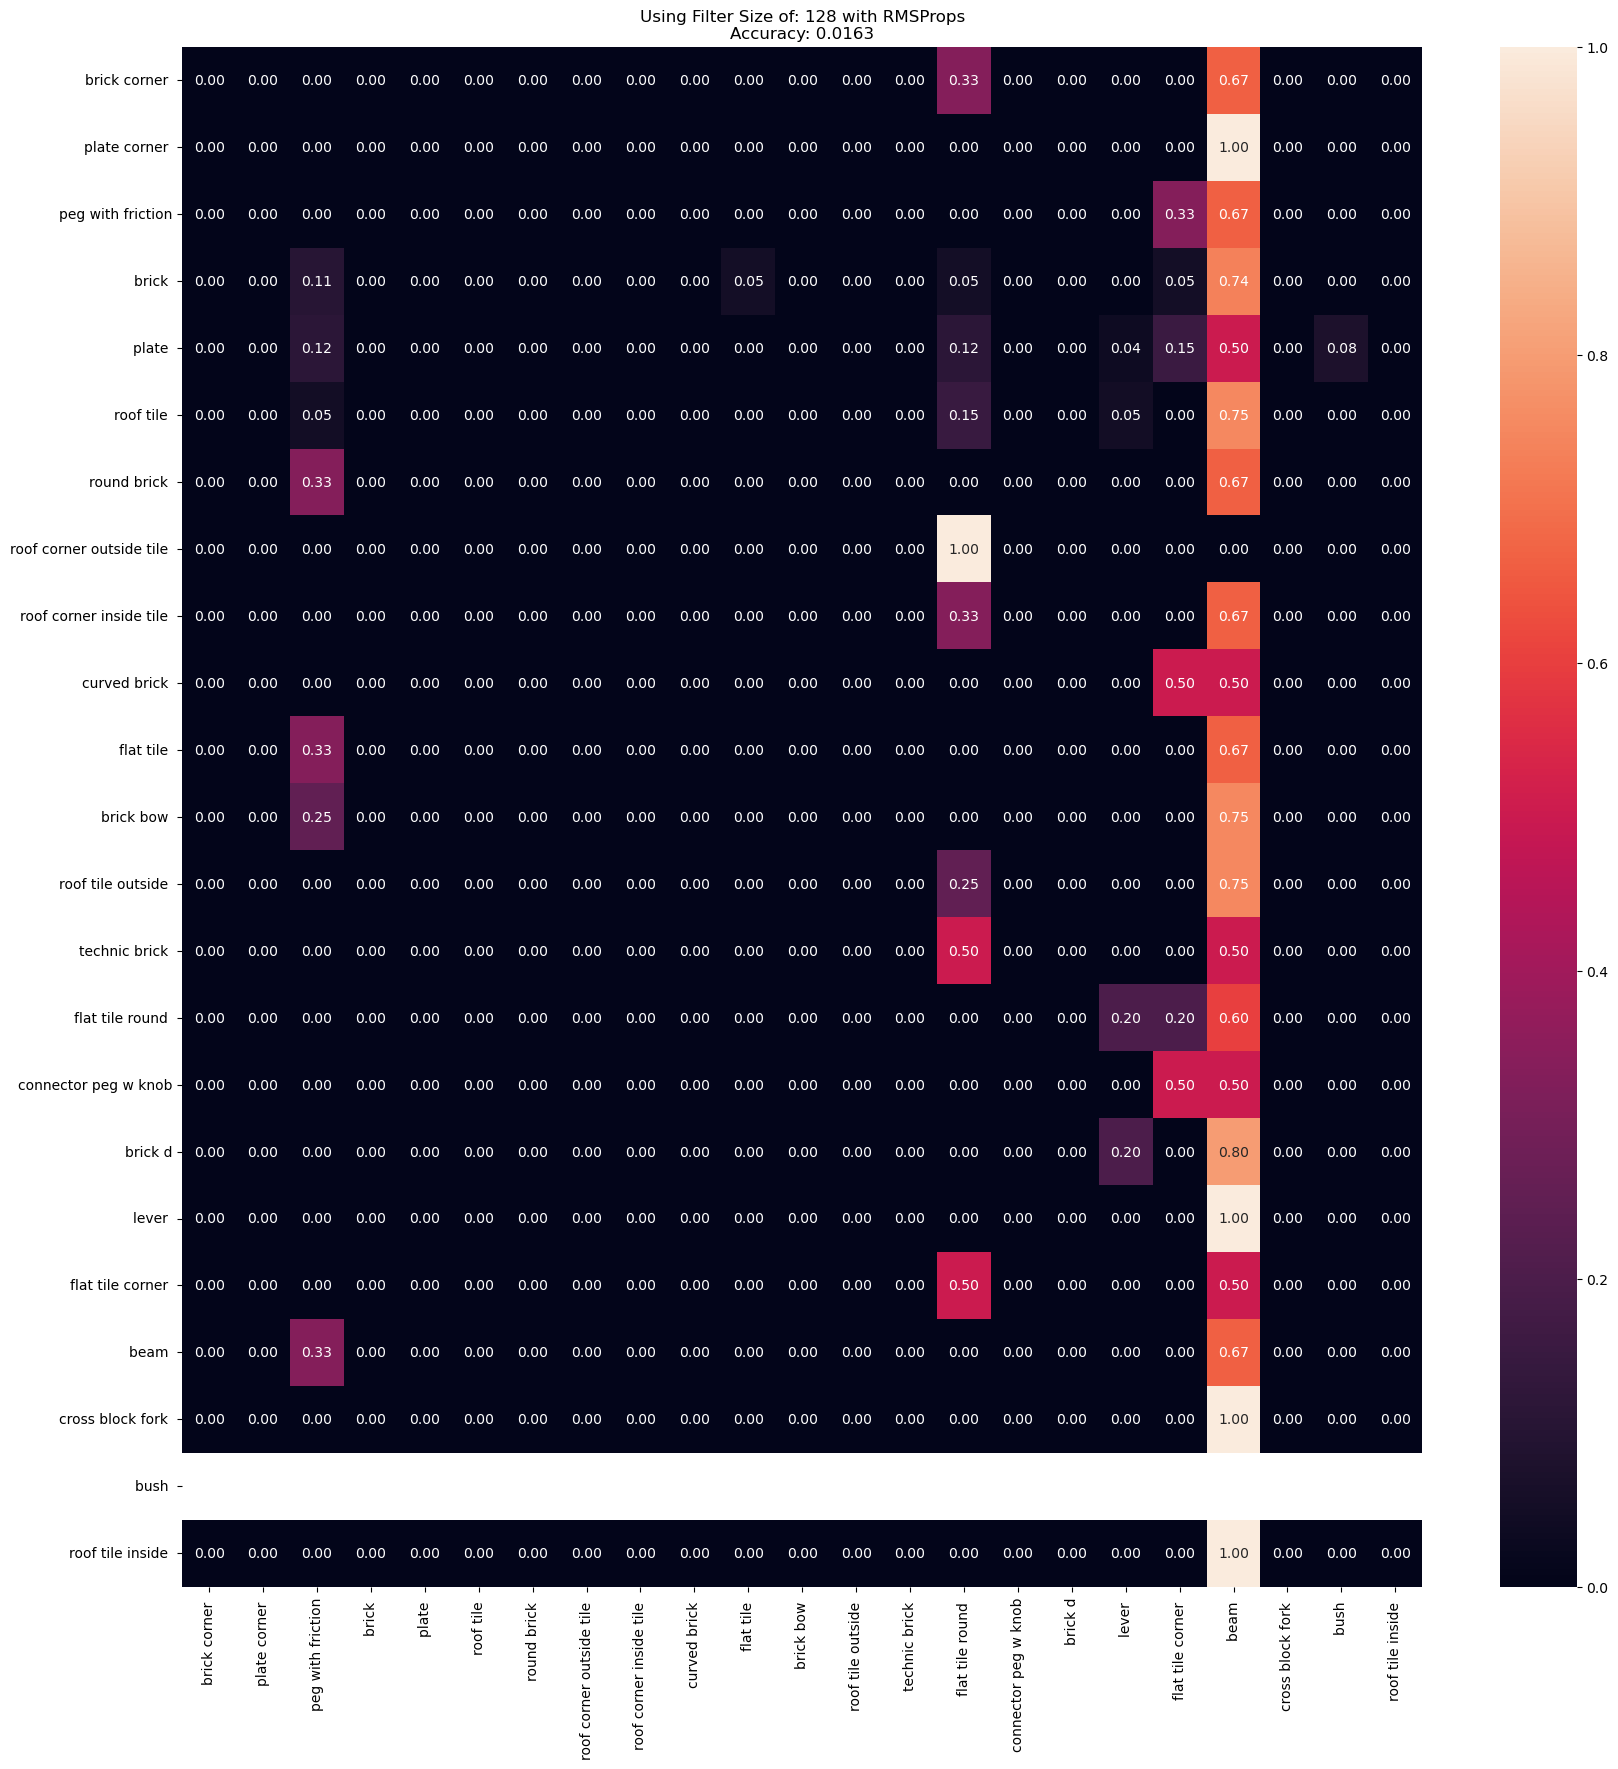

In [13]:
cnn = create_cnn(filter_at_highest, kernel_size)

summarize_net(cnn, X_test, y_test, title_text='Using Filter Size of: ' + str(filter_at_highest) + " with RMSProps")

##### Model 2

Alternatively, I ran the above test again but with ADAdelta. It remained consistent with what we have seen, where 128 was the ideal number of filters, and it was only able to identify one category. 

In [16]:
highest_acc = -1
filters_at_highest = -1
filters = 8
while filters < 128 : 
    kernel_size = 3
    filters *=2
    
    cnn = create_cnn(filters, kernel_size)
    cnn = compile_ADA(cnn)
    acc = determine_accuracy(cnn, X_test, y_test)
    if(acc > highest_acc) :
        highest_acc = acc
        filters_at_highest = filters

/tmp/ipykernel_27156/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 67.1635 - accuracy: 0.0222 - val_loss: 40.1794 - val_accuracy: 0.0569
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 64.5768 - accuracy: 0.0249 - val_loss: 37.1457 - val_accuracy: 0.0569
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 61.4922 - accuracy: 0.0499 - val_loss: 34.3736 - val_accuracy: 0.0650
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 57.9983 - accuracy: 0.0526 - val_loss: 31.8380 - val_accuracy: 0.0650
Epoch 5/5
4/4 [==============================] - 1s 120ms/step


/tmp/ipykernel_27156/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 17s 6s/step - loss: 17.1748 - accuracy: 0.0443 - val_loss: 8.2446 - val_accuracy: 0.0407
Epoch 2/5
3/3 [==============================] - 17s 6s/step - loss: 15.5896 - accuracy: 0.0469 - val_loss: 6.7409 - val_accuracy: 0.0569
Epoch 3/5
3/3 [==============================] - 16s 6s/step - loss: 13.0981 - accuracy: 0.0748 - val_loss: 6.0088 - val_accuracy: 0.0894
Epoch 4/5
3/3 [==============================] - 16s 5s/step - loss: 12.8202 - accuracy: 0.0637 - val_loss: 5.5627 - val_accuracy: 0.1220
Epoch 5/5
4/4 [==============================] - 1s 272ms/step


/tmp/ipykernel_27156/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 54s 19s/step - loss: 15.2554 - accuracy: 0.0443 - val_loss: 11.4369 - val_accuracy: 0.0325
Epoch 2/5
3/3 [==============================] - 53s 19s/step - loss: 13.2607 - accuracy: 0.0360 - val_loss: 8.8921 - val_accuracy: 0.0325
Epoch 3/5
3/3 [==============================] - 56s 19s/step - loss: 12.0128 - accuracy: 0.0391 - val_loss: 7.0887 - val_accuracy: 0.0407
Epoch 4/5
3/3 [==============================] - 53s 18s/step - loss: 10.8733 - accuracy: 0.0360 - val_loss: 5.9128 - val_accuracy: 0.0732
Epoch 5/5
4/4 [==============================] - 4s 931ms/step


/tmp/ipykernel_27156/194493443.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 225s 78s/step - loss: 10.1972 - accuracy: 0.1042 - val_loss: 5.0971 - val_accuracy: 0.1463
Epoch 2/5
3/3 [==============================] - 212s 71s/step - loss: 8.9878 - accuracy: 0.1025 - val_loss: 4.2397 - val_accuracy: 0.1626
Epoch 3/5
3/3 [==============================] - 212s 78s/step - loss: 7.5027 - accuracy: 0.0970 - val_loss: 3.7095 - val_accuracy: 0.1707
Epoch 4/5
3/3 [==============================] - 212s 72s/step - loss: 6.3271 - accuracy: 0.0914 - val_loss: 3.3547 - val_accuracy: 0.1789
Epoch 5/5
4/4 [==============================] - 18s 4s/step


4/4 [==============================] - 17s 4s/step


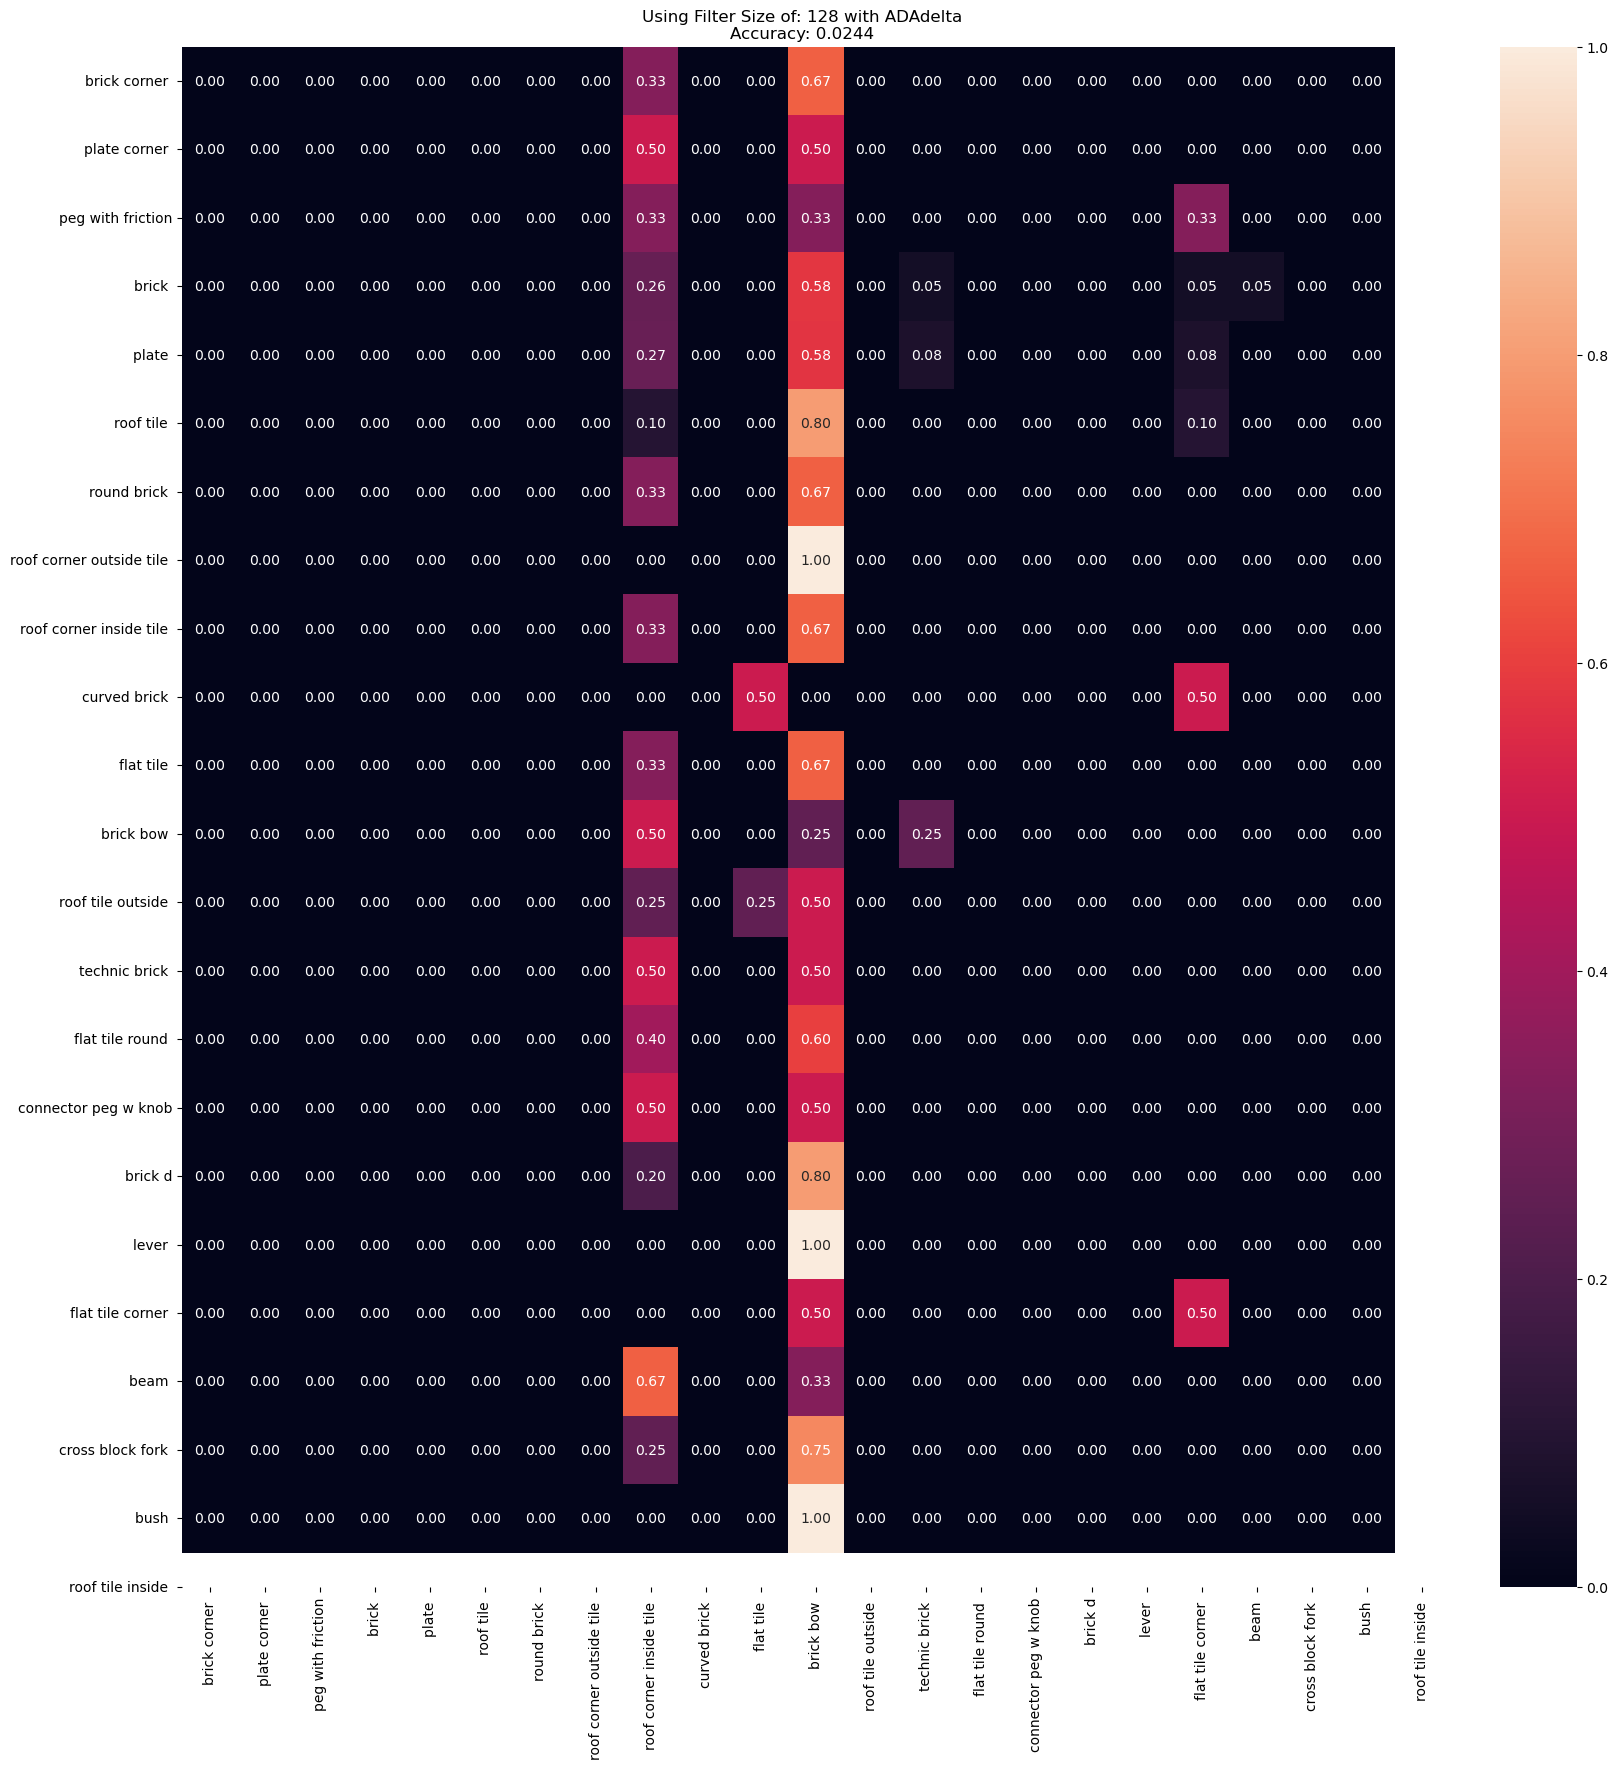

In [18]:
cnn = create_cnn(filters_at_highest, kernel_size)

summarize_net(cnn, X_test, y_test, title_text='Using Filter Size of: ' + str(filters_at_highest) + " with ADAdelta")

#### Architecture 3

Now that I have a general grasp on what the the kernels and filters affects are, I combine the two and utilized our adadelta function to what our optimal results are with out convolutional neural network. It has roughly around a 22% accuracy, which is still lower than we would generally like to be. And it is also mostly focused on recognizing one class. 

In [10]:
cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=128,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(5,5), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=128,
                kernel_size=(5,5), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adadelta', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

2022-12-04 22:43:43.074100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 22:43:43.074279: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/tmp/ipykernel_8683/892623086.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 508s 175s/step - loss: 11.2123 - accuracy: 0.0651 - val_loss: 5.7985 - val_accuracy: 0.1545
Epoch 2/5
3/3 [==============================] - 510s 177s/step - loss: 9.5843 - accuracy: 0.0495 - val_loss: 5.1238 - val_accuracy: 0.1707
Epoch 3/5
3/3 [==============================] - 519s 180s/step - loss: 7.9392 - accuracy: 0.0911 - val_loss: 4.1337 - val_accuracy: 0.1789
Epoch 4/5
3/3 [==============================] - 523s 181s/step - loss: 6.5935 - accuracy: 0.0677 - val_loss: 3.6833 - val_accuracy: 0.1789
Epoch 5/5
3/3 [==============================] - 532s 184s/step - loss: 5.9225 - accuracy: 0.0859 - val_loss: 3.3990 - val_accuracy: 0.1301


4/4 [==============================] - 37s 9s/step


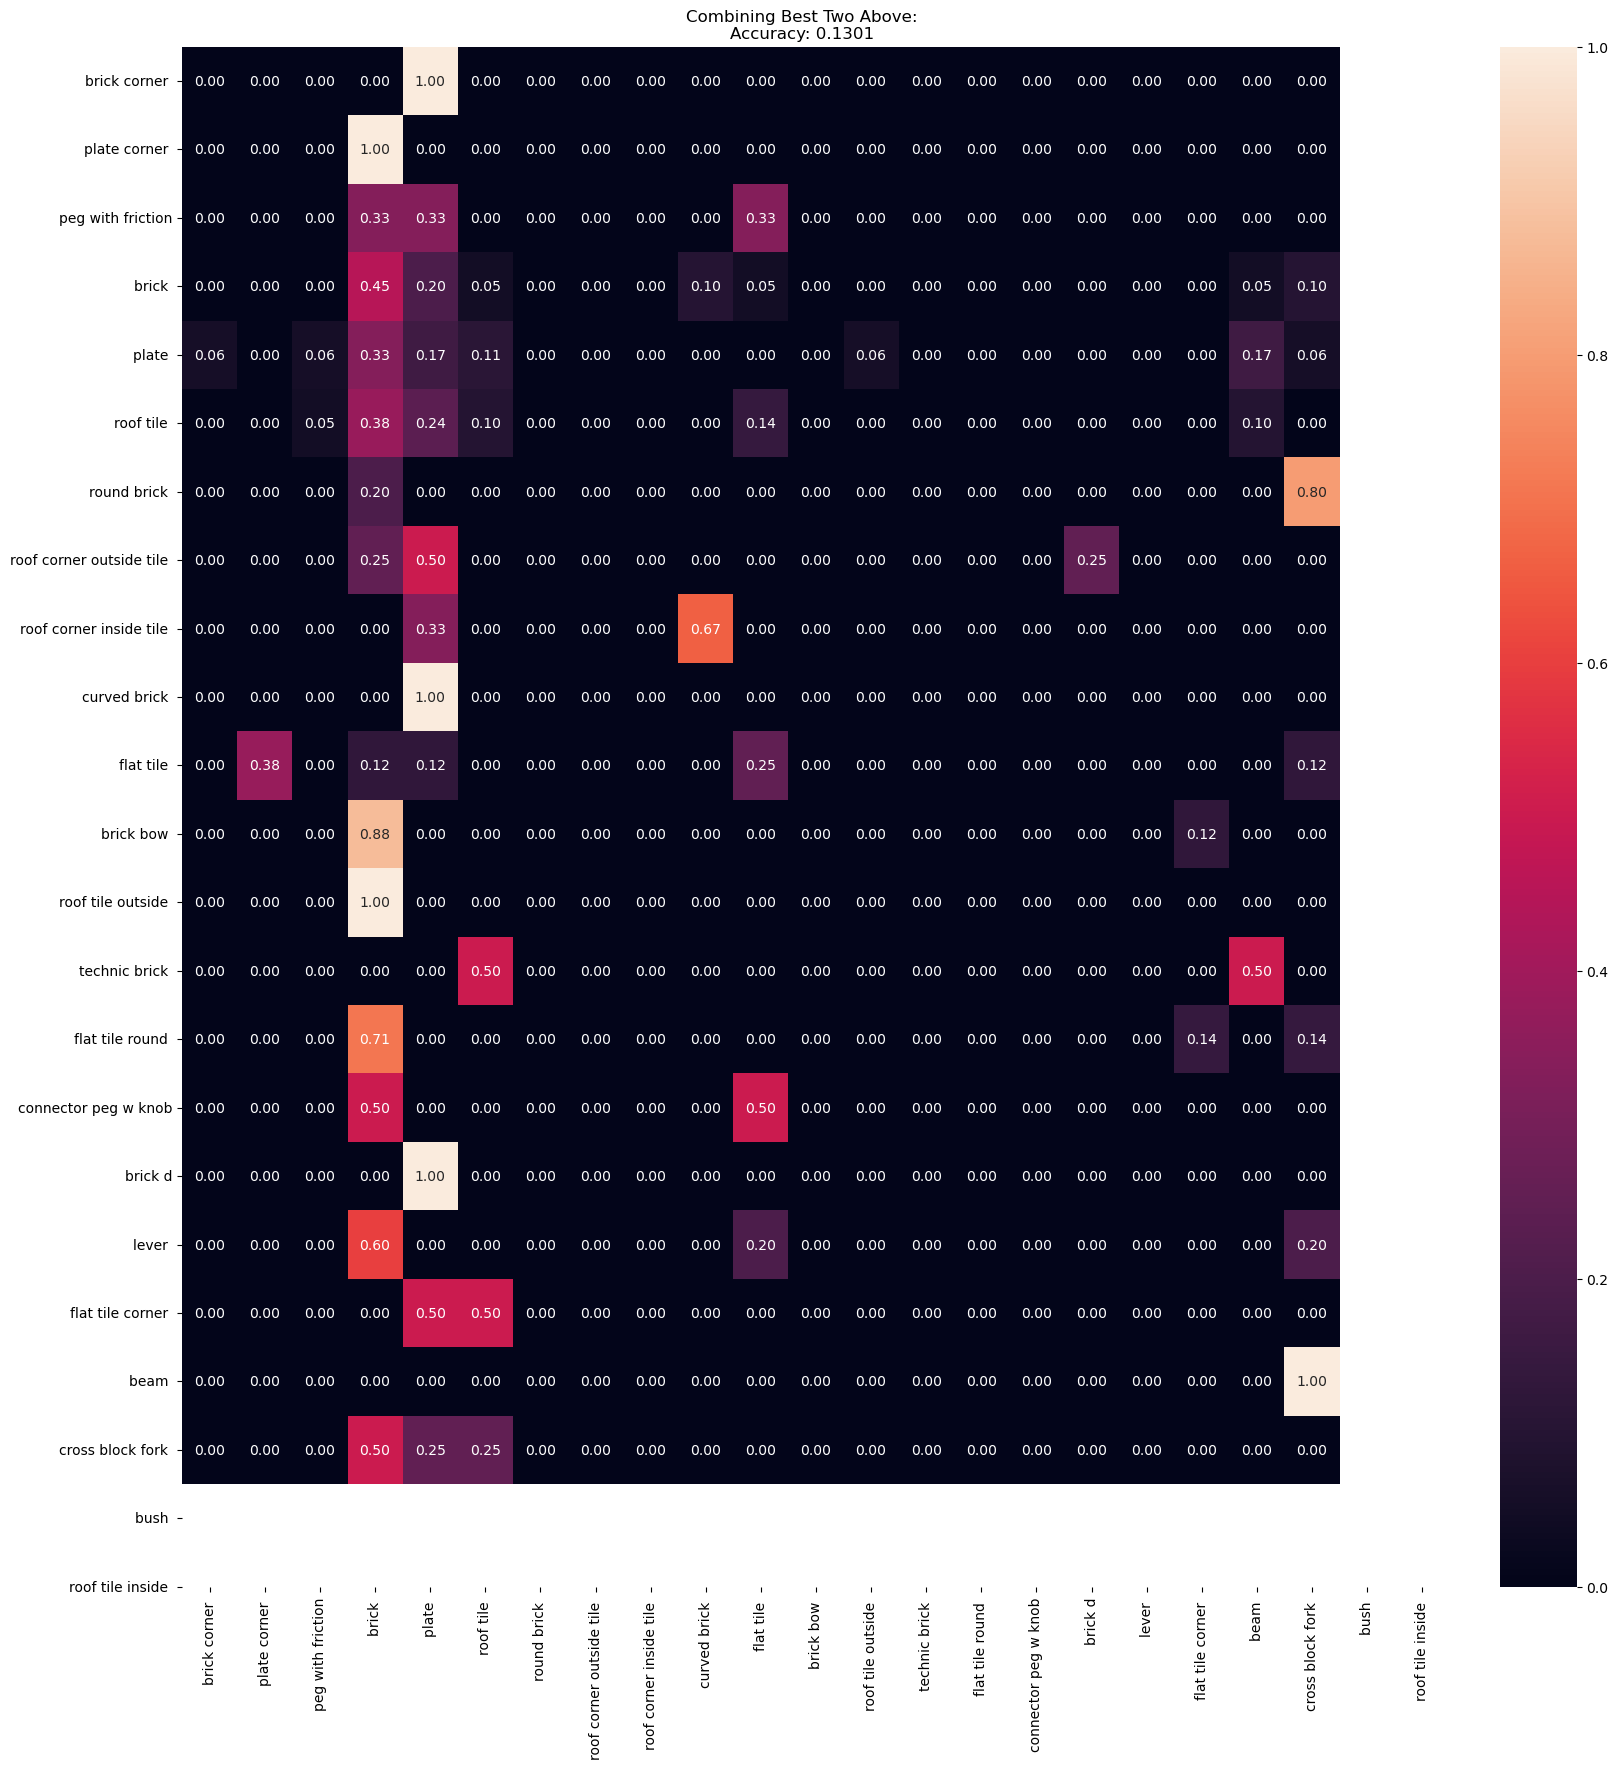

In [11]:
summarize_net(cnn, X_test, y_test, title_text='Combining Best Two Above:')

#### Architecture 4

Finally, to add more accuracy given my current lack of resources and my inability to add epochs. I chose to add another two layers onto the network, to see how it was able to improve accuracy. From this below network, it appears that my chosen methodology does not work particularly well, so the mulitple layers add minimal affect. 

In [14]:
cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=128,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(5,5), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=128,
                kernel_size=(5,5), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(Conv2D(filters=128,
                kernel_size=(5,5), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(Conv2D(filters=128,
                kernel_size=(5,5), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adadelta', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history = cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

/tmp/ipykernel_33279/2183463239.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
3/3 [==============================] - 1481s 492s/step - loss: 5.0909 - accuracy: 0.0526 - val_loss: 3.1496 - val_accuracy: 0.1545
Epoch 2/5
3/3 [==============================] - 1457s 489s/step - loss: 4.2050 - accuracy: 0.0748 - val_loss: 3.0484 - val_accuracy: 0.1626
Epoch 3/5
3/3 [==============================] - 1556s 537s/step - loss: 3.9772 - accuracy: 0.0885 - val_loss: 2.9758 - val_accuracy: 0.1220
Epoch 4/5
3/3 [==============================] - 1444s 481s/step - loss: 3.5814 - accuracy: 0.1053 - val_loss: 2.9223 - val_accuracy: 0.1463
Epoch 5/5
3/3 [==============================] - 1455s 489s/step - loss: 3.4046 - accuracy: 0.1385 - val_loss: 2.8880 - val_accuracy: 0.0976


4/4 [==============================] - 108s 27s/step


/tmp/ipykernel_33279/796560467.py:13: RuntimeWarning: invalid value encountered in divide
  cm = cm/np.sum(cm,axis=1)[:,np.newaxis]


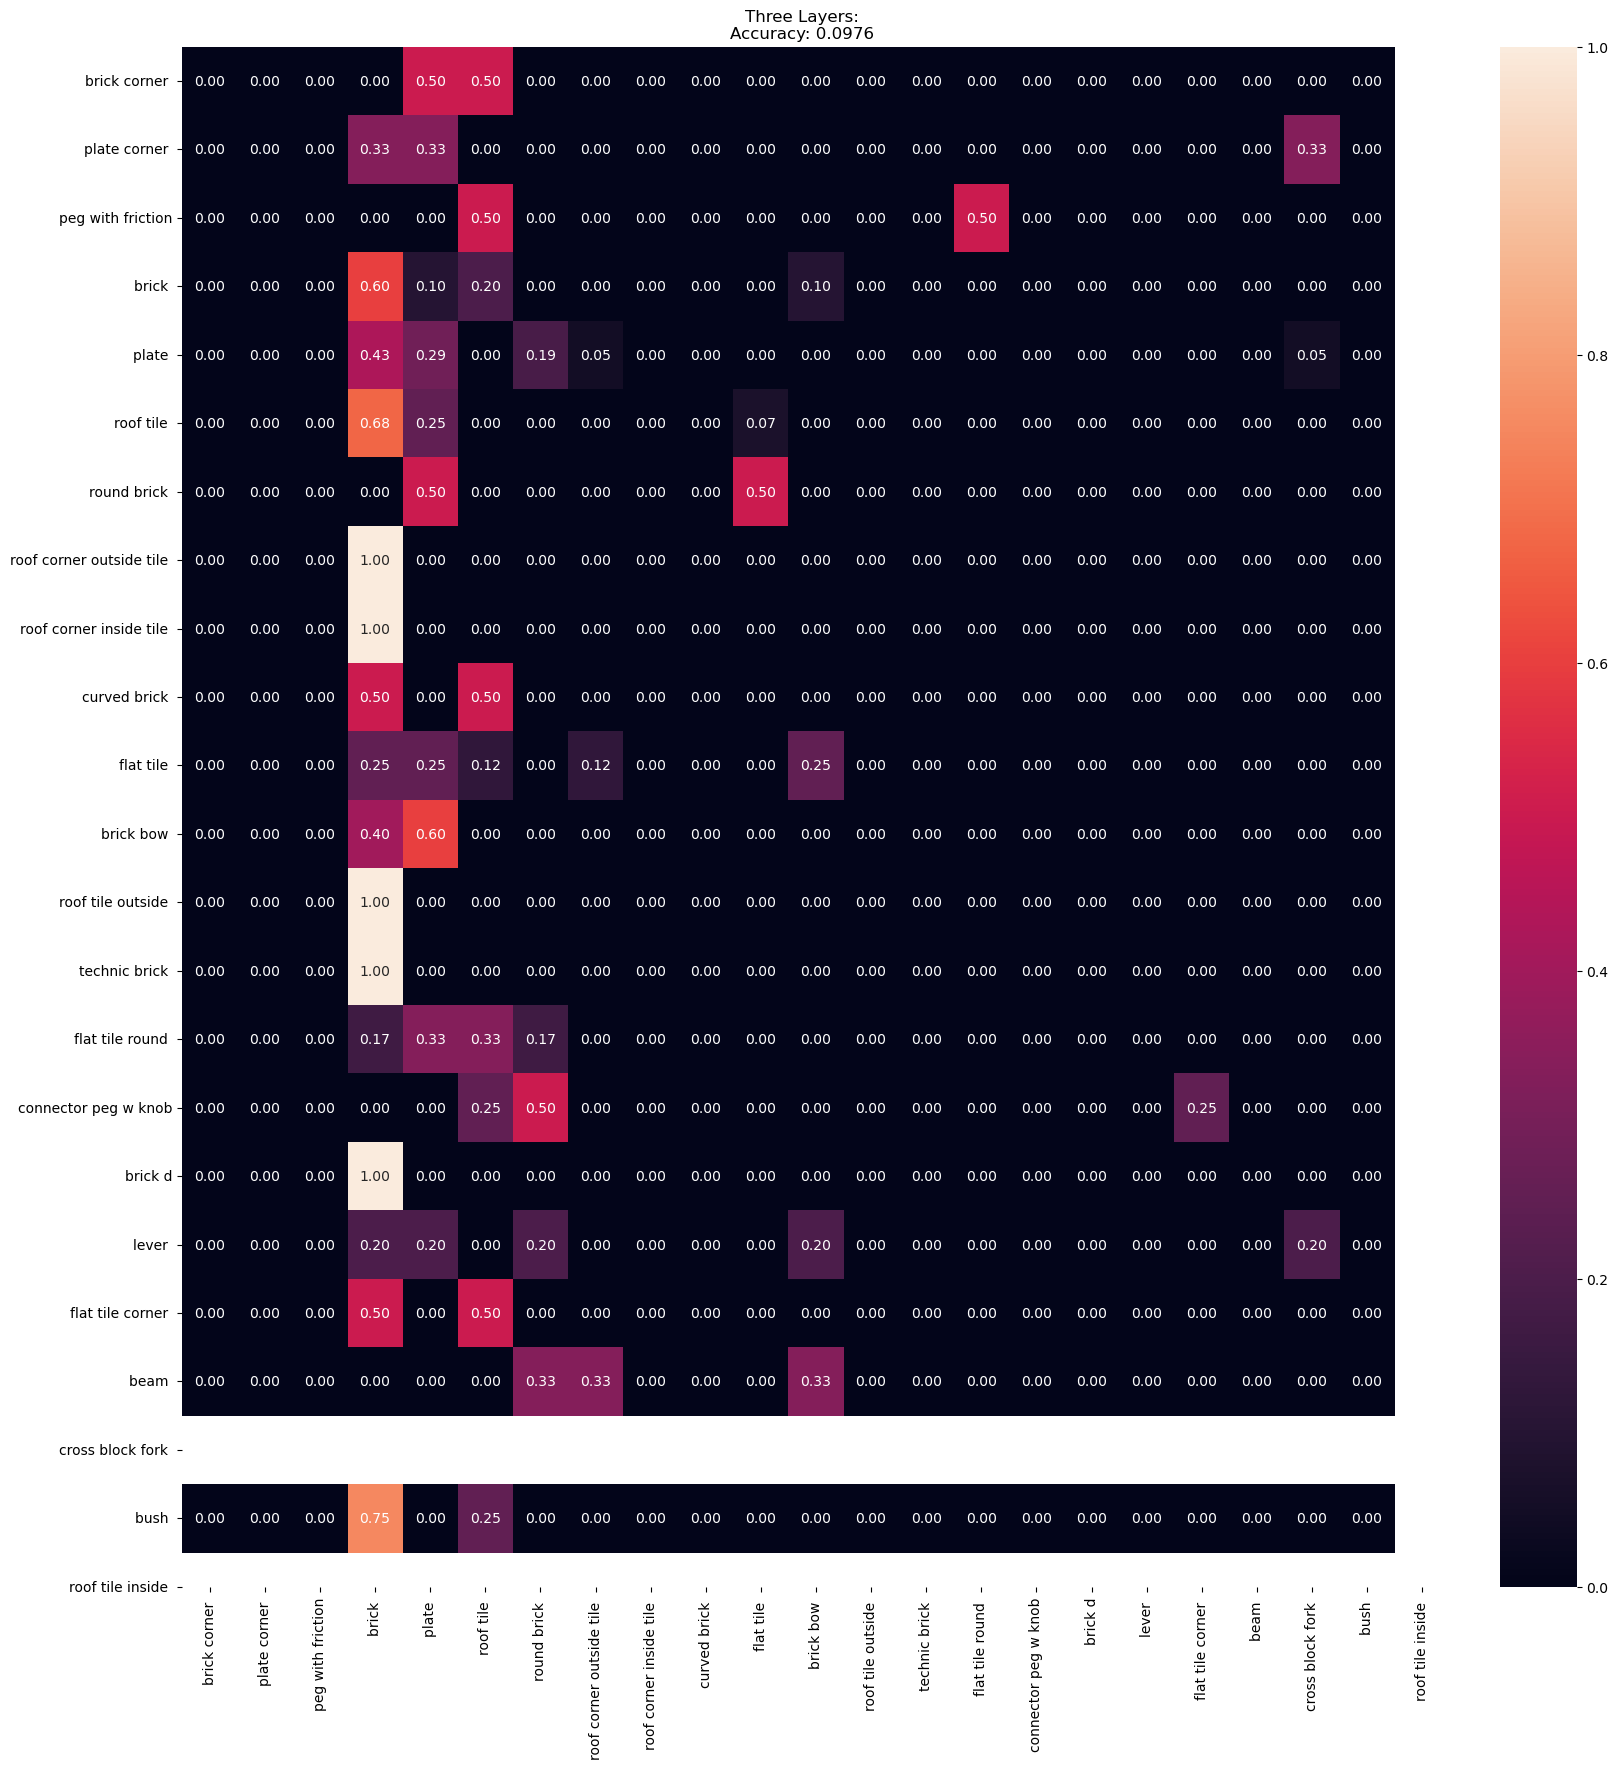

In [16]:
summarize_net(cnn, X_test, y_test, title_text='Three Layers:')

### Analyze Performance

Now that we have our final model, I graphed the history and we can see that they do progressively converge as time goes along. At around 3.5 epochs, training and testing do converge, which implies that more epochs would lead to higher accuracy. 

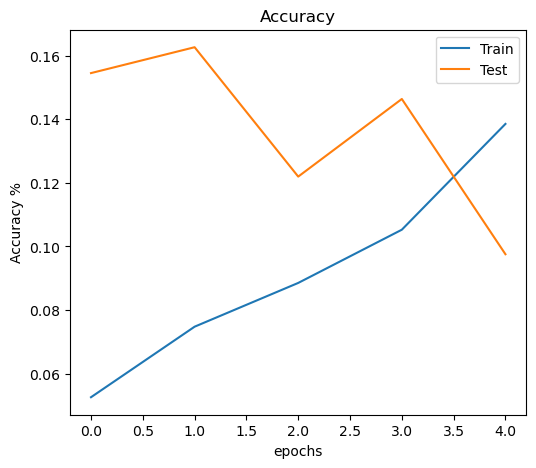

In [17]:
#Show the loss and the accuracy at the model at each epoch
plt.figure(figsize=(20, 5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,3,3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy %')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(['Train', 'Test'], loc='best')

plt.show()

In [18]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = model_multiclass.classes_
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

NameError: name 'model_multiclass' is not defined

<Figure size 1200x800 with 0 Axes>

### Analysis in Comparison

To finalize my comparisons, I compared the performance of the above Convolutional Neural Network with the performance of a simple Multi-layer Perceptron. 

In [22]:
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

history = mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)


Epoch 1/15
16/16 [==============================] - 1s 15ms/step - loss: 33.5112 - accuracy: 0.0123
Epoch 2/15
16/16 [==============================] - 0s 15ms/step - loss: 28.3871 - accuracy: 0.0102
Epoch 3/15
16/16 [==============================] - 0s 15ms/step - loss: 24.9311 - accuracy: 0.0061
Epoch 4/15
16/16 [==============================] - 0s 15ms/step - loss: 22.4875 - accuracy: 0.0123
Epoch 5/15
16/16 [==============================] - 0s 15ms/step - loss: 20.6601 - accuracy: 0.0164
Epoch 6/15
16/16 [==============================] - 0s 15ms/step - loss: 19.1535 - accuracy: 0.0225
Epoch 7/15
16/16 [==============================] - 0s 14ms/step - loss: 17.9651 - accuracy: 0.0266
Epoch 8/15
16/16 [==============================] - 0s 15ms/step - loss: 16.9239 - accuracy: 0.0266
Epoch 9/15
16/16 [==============================] - 0s 15ms/step - loss: 16.0134 - accuracy: 0.0368
Epoch 10/15
16/16 [==============================] - 0s 14ms/step - loss: 15.2084 - accuracy: 0.0327

4/4 [==============================] - 85s 21s/step


/tmp/ipykernel_33279/972679229.py:8: RuntimeWarning: invalid value encountered in divide
  cm = cm/np.sum(cm,axis=1)[:,np.newaxis]


4/4 [==============================] - 0s 6ms/step


/tmp/ipykernel_33279/972679229.py:18: RuntimeWarning: invalid value encountered in divide
  cm = cm/np.sum(cm,axis=1)[:,np.newaxis]


Text(0.5, 1.0, 'MLP: 0.04065040650406504')

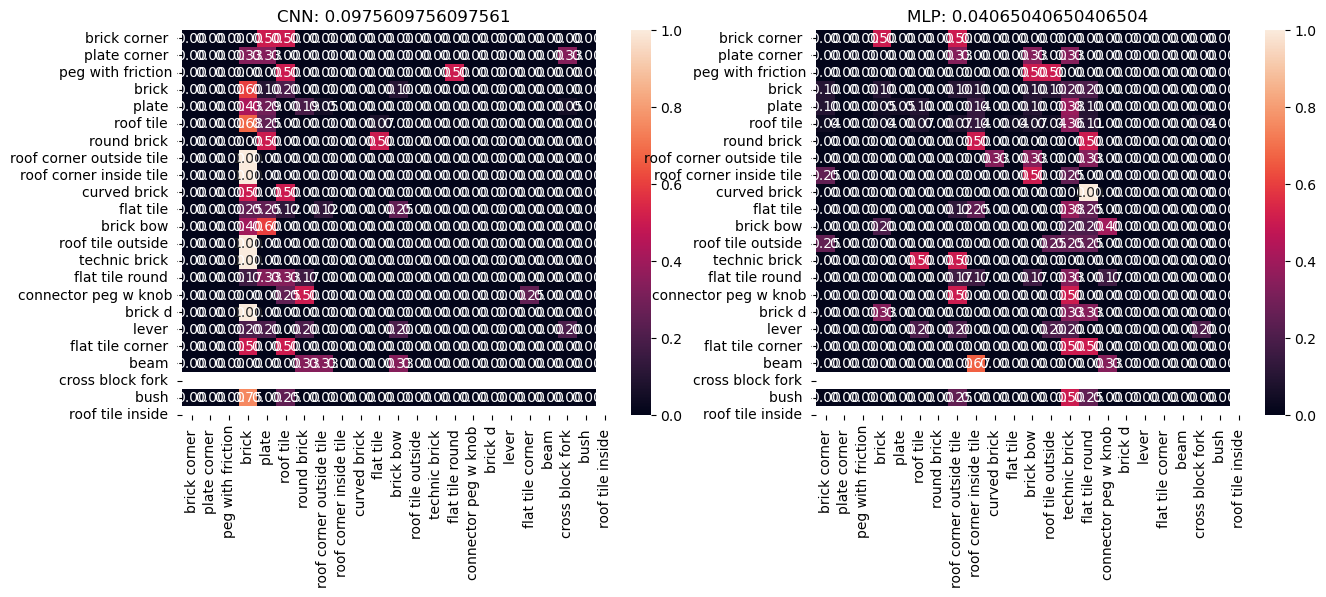

In [24]:
plt.figure(figsize=(15,5))
yhat = np.argmax(cnn.predict(X_test), axis=1)
yhat = np.asarray(yhat, dtype=np.float64)
y_test =  np.asarray(y_test, dtype=np.float64)
acc = mt.accuracy_score(y_test,yhat)
plt.subplot(1,2,1)
cm = mt.confusion_matrix(y_test,yhat)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
plt.title('CNN: '+str(acc))
        
yhat = np.argmax(mlp.predict(X_test), axis=1)
yhat = np.asarray(yhat, dtype=np.float64)
y_test =  np.asarray(y_test, dtype=np.float64)
acc = mt.accuracy_score(y_test,yhat)
plt.subplot(1,2,2)
cm = mt.confusion_matrix(y_test,yhat)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
plt.title('MLP: '+str(acc))

In [ ]:
#Show the loss and the accuracy at the model at each epoch
plt.figure(figsize=(20, 5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend(['Train', 'Test'], loc='best')

plt.subplot(1,3,3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy %')
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(['Train', 'Test'], loc='best')

plt.show()